# Optimum Fit atmosphere of parameters including clouds  using wavelet decomposition of transparency

- author Sylvie Dagoret-Campagne

- creation date August 20th 2020 


In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline

In [45]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (12, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score,explained_variance_score

In [47]:
sys.path.append("../../tools/atmanalyticsim") # go to parent dir

In [48]:
import libatmscattering as atm

In [49]:
def plot_coeffs(coeff,ilevel_label,Nsamp=20,Yscalelog=True):
    
    N=Nsamp
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    fig=plt.figure(figsize=(15,3))
    ax = fig.add_subplot(111)
    for idx in np.arange(Nsamp):
        #ax.plot(coeff[idx,:],"o-",color=all_colors[idx])
        ax.plot(coeff[idx,:],"o-")
    if Yscalelog:
        ax.set_yscale("symlog")
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax.grid()
    ax.set_title("wavelets coefficients with clouds "+ ilevel_label)
    ax.set_xlabel("coefficient index")
    ax.set_ylabel("coefficient value")
     
    plt.show()

In [50]:
def plot_learningcurves(nsamples,all_MSE_train,all_MSE_test,ilevel_label):
    fig=plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)
    ax.plot(nsamples, all_MSE_train,'b-o',label="train")
    ax.plot(nsamples, all_MSE_test,'r-o',label="test")
    ax.legend()
    ax.set_yscale("log")
    ax.set_xlabel("$N$")
    ax.set_ylabel("MSE")
    ax.set_title("MSE with test vs N, "+" "+ ilevel_label)
    ax.grid()
    ax1 = ax.twinx()
    ax1.set_ylim(ax.get_ylim())
    ax1.set_yscale("log")
    ax1.grid()
    plt.show()

# Input files : wavelet decomposition coefficients

In [51]:
all_files=["lsst_atm_10year_wavelets_dataset1_cld.fits",
           "lsst_atm_10year_wavelets_dataset2_cld.fits",
           "lsst_atm_10year_wavelets_dataset3_cld.fits",
           "lsst_atm_10year_wavelets_dataset4_cld.fits",
           "lsst_atm_10year_wavelets_dataset5_cld.fits",
           "lsst_atm_10year_wavelets_dataset6_cld.fits",
           "lsst_atm_10year_wavelets_dataset7_cld.fits",
           "lsst_atm_10year_wavelets_dataset8_cld.fits",
           "lsst_atm_10year_wavelets_dataset9_cld.fits"]

In [52]:
Nlevel=len(all_files)

## Loop on Levels

- ilevel : from 1 to 9

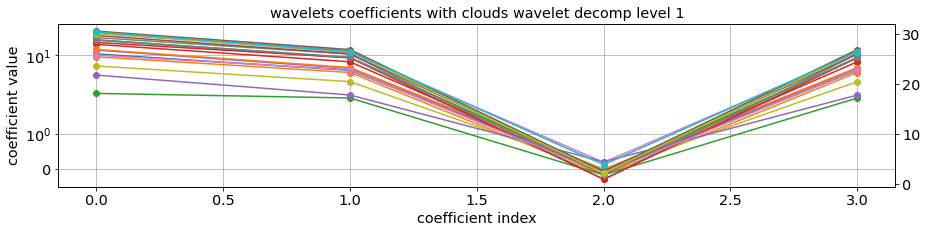

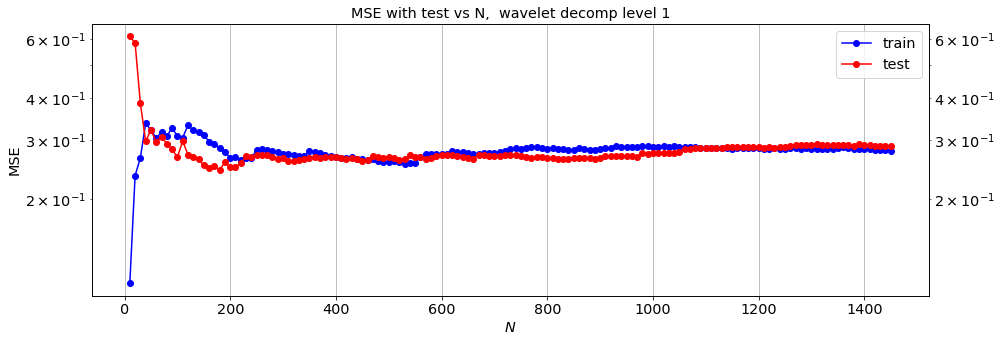

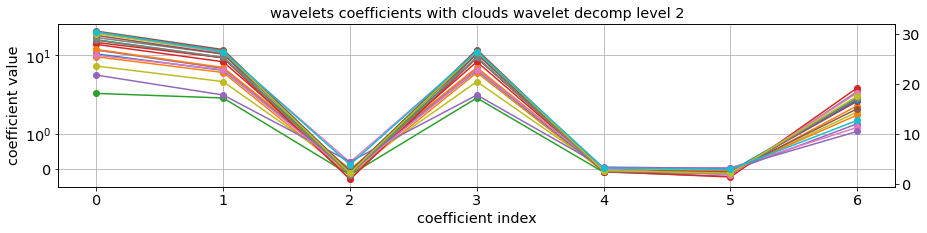

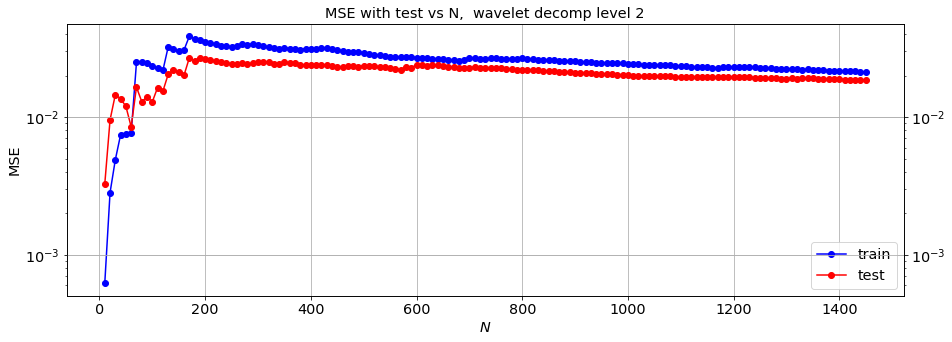

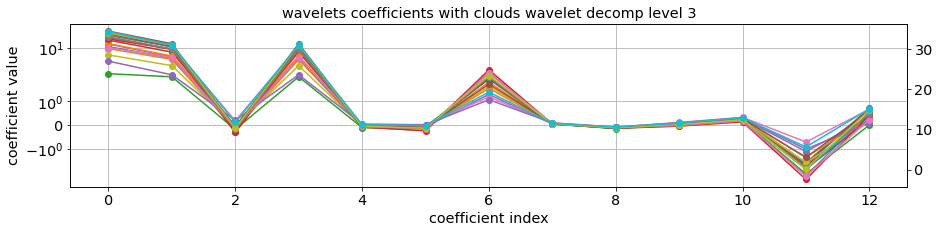

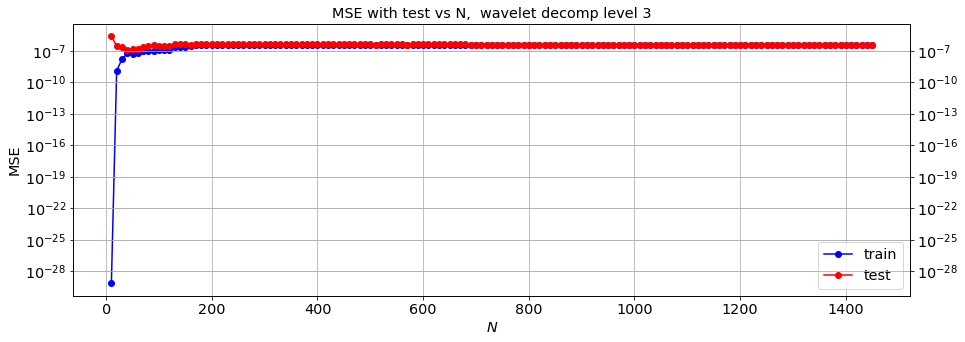

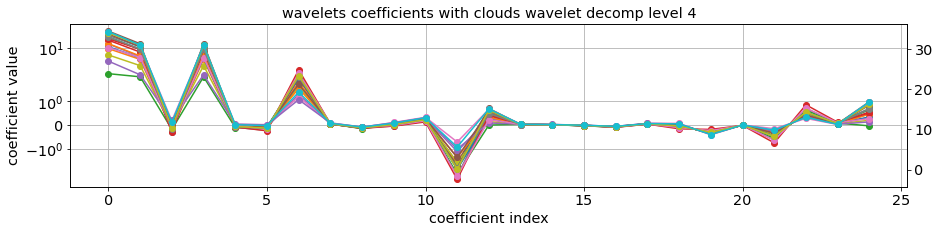

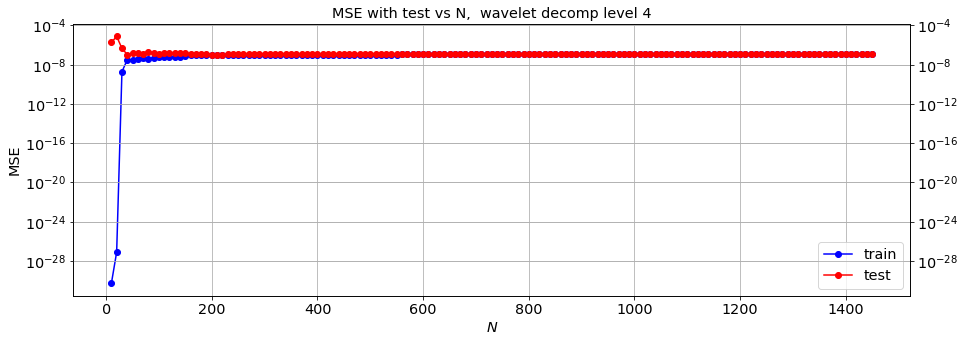

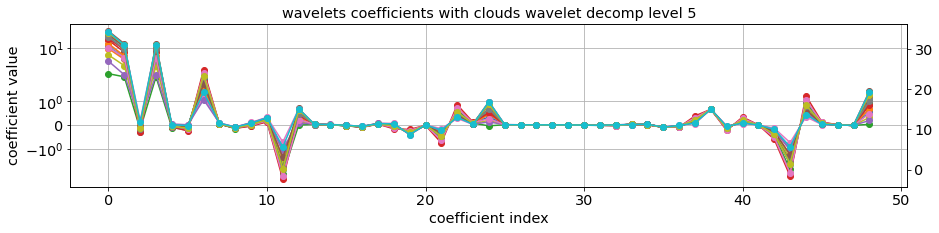

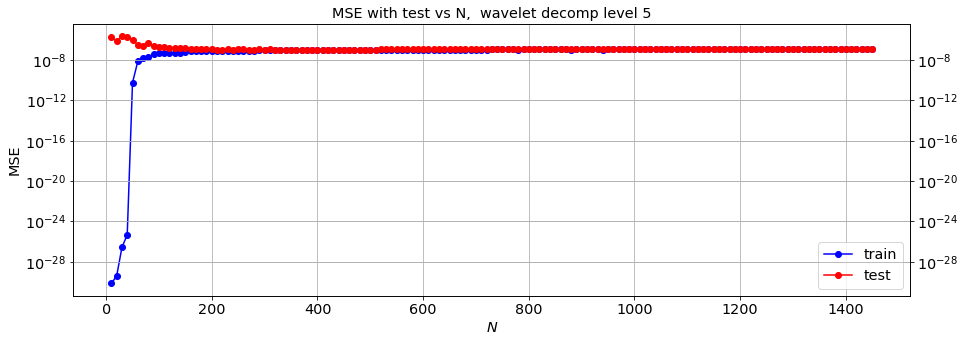

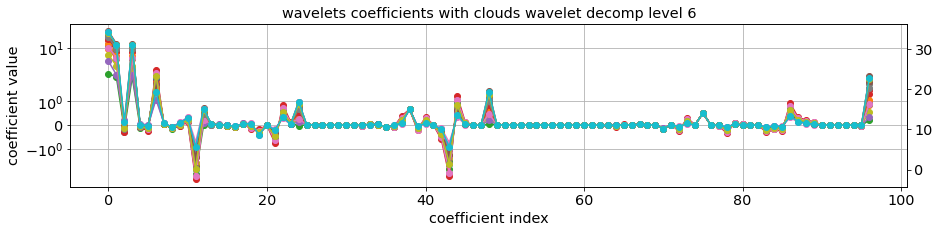

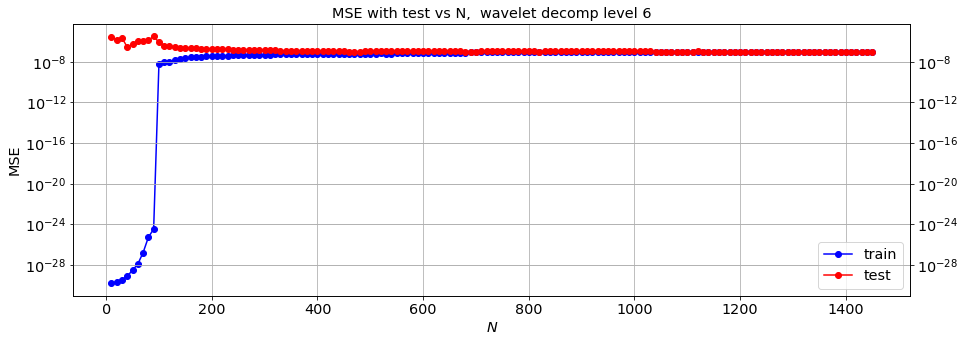

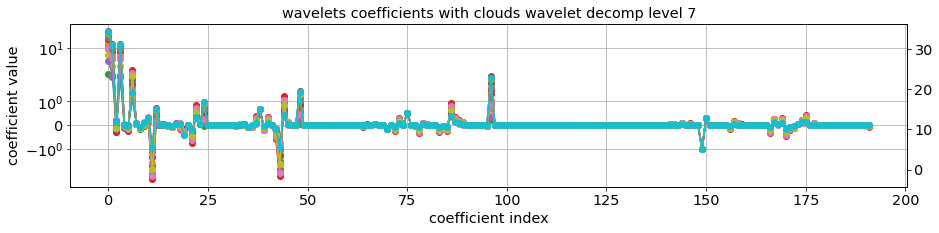

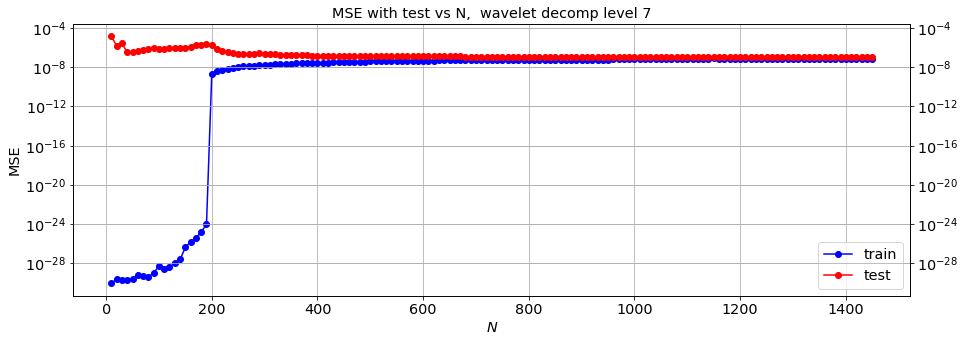

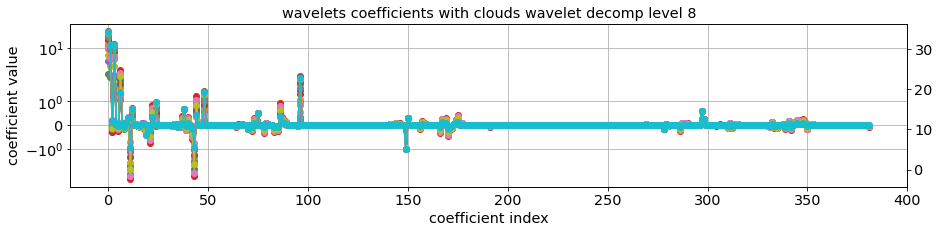

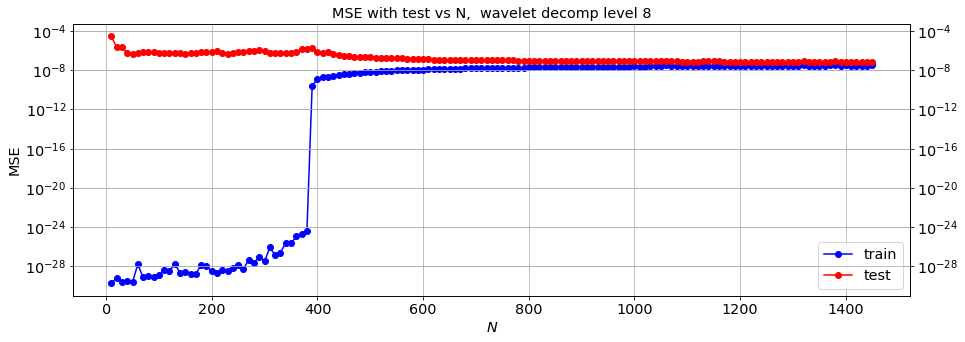

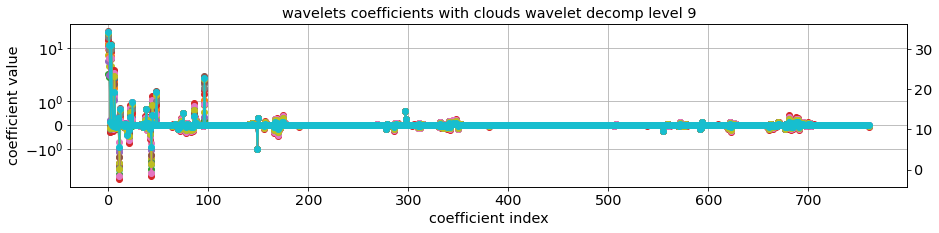

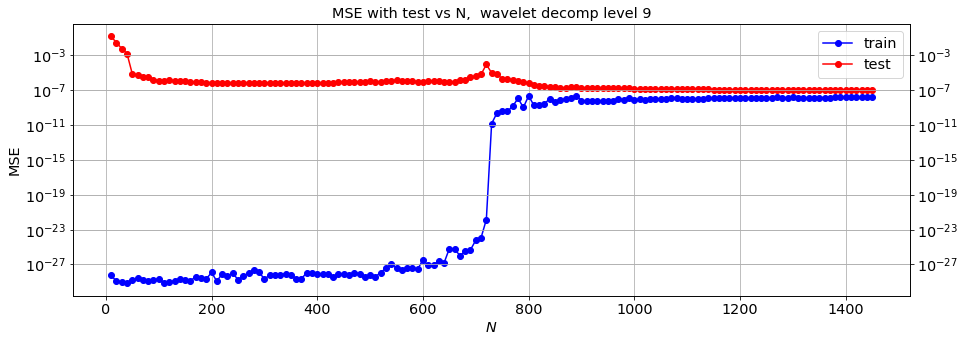

In [53]:
all_MSE_train=[]
all_MSE_test=[]
all_Yin=[]
all_Yout=[]


for ilevel in np.arange(1,Nlevel+1):
    # level of decomposition
    ilevel_label="wavelet decomp level {}".format(ilevel)
    
    # input file
    input_file=all_files[ilevel-1]
    hdu = fits.open(input_file)
    
    # extraction
    hdr=hdu[0].header
    data=hdu[0].data
    
    NbAtmSimul=hdr['NBATMSIM']
    idx_out_num=hdr['ID_NUM']
    idx_out_year=hdr['ID_YEAR']
    idx_out_am=hdr['ID_AM']
    idx_out_vaod=hdr['ID_VAOD']
    idx_out_pwv=hdr['ID_PWV']
    idx_out_o3=hdr['ID_O3']
    idx_out_cld=hdr['ID_CLD']
    idx_out_res=hdr['ID_RES']
    
    
    num=data[0:,idx_out_num]
    year=data[0:,idx_out_year]
    airmass=data[0:,idx_out_year]
    vaod=data[0:,idx_out_vaod] # vertical aerosol depth
    pwv=data[0:,idx_out_pwv]   # precipitable water vapor (mm)
    o3=data[0:,idx_out_o3]     # ozone
    cld=data[0:,idx_out_cld]   # clouds (not used)
    
    
    coeff=data[:,idx_out_res:]
    
    N=coeff.shape[1]
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    
    plot_coeffs(coeff,ilevel_label,Nsamp=20,Yscalelog=True)
    
    
    #prepare (X,Y) for the fit
    
    ## Y
    vaodarr=vaod[:,np.newaxis]
    pwvarr=pwv[:,np.newaxis]
    o3arr=o3[:,np.newaxis]
    cldarr=cld[:,np.newaxis]
    
    Y=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
    
    ## X
    X=coeff
    
    
    ## Splitting
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
    #X_val,X_test,Y_val,Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)
    
    ## Scaling
    scaler_X = StandardScaler()
    scaler_Y = StandardScaler()
    
    scaler_X.fit(X_train) 
    scaler_Y.fit(Y_train) 
    
    X_train_scaled = scaler_X.transform(X_train)
    Y_train_scaled = scaler_Y.transform(Y_train)    
    #X_val_scaled = scaler_X.transform(X_val)
    #Y_val_scaled = scaler_Y.transform(Y_val)
    X_test_scaled = scaler_X.transform(X_test)
    Y_test_scaled = scaler_Y.transform(Y_test)
    
    nb_tot_test=len(Y_test)
    nsamples=np.arange(10,nb_tot_test,10)
    
    curv_MSE_train=np.zeros(len(nsamples))
    curv_MSE_test=np.zeros(len(nsamples))
    
    # loop on samples
    count=0
    for n in nsamples:
    
        regr = linear_model.LinearRegression(fit_intercept=True)
         
        X_train_cut=np.copy(X_train_scaled[:n,:])
        Y_train_cut=np.copy(Y_train_scaled[:n,:] ) 
        X_test_cut=np.copy(X_test_scaled[:n,:])
        Y_test_cut=np.copy(Y_test_scaled[:n,:] ) 
    
        regr.fit(X_train_cut,Y_train_cut)
    
    
        # calculate metric
        # Make predictions using the testing set
        Y_pred_train = regr.predict(X_train_cut)
        Y_pred_test  = regr.predict(X_test_cut)
    
        MSE_train=mean_squared_error(Y_train_cut, Y_pred_train)
        MSE_test=mean_squared_error(Y_test_cut, Y_pred_test)

        curv_MSE_train[count]=MSE_train
        curv_MSE_test[count]=MSE_test
    
        count+=1
        # end of loop on samples
    
    plot_learningcurves(nsamples,curv_MSE_train,curv_MSE_test,ilevel_label)
    
    
    # backup learning curves
    all_MSE_train.append(curv_MSE_train)
    all_MSE_test.append(curv_MSE_test)
    
    # Backup estimated atm parameters
    
    # must inverse transform
    all_Yin.append(scaler_Y.inverse_transform(Y_test_cut))
    all_Yout.append(scaler_Y.inverse_transform(Y_pred_test))
    
    
    hdu.close()
    
    # end of loop on ilevel
    

Text(0, 0.5, 'MSE')

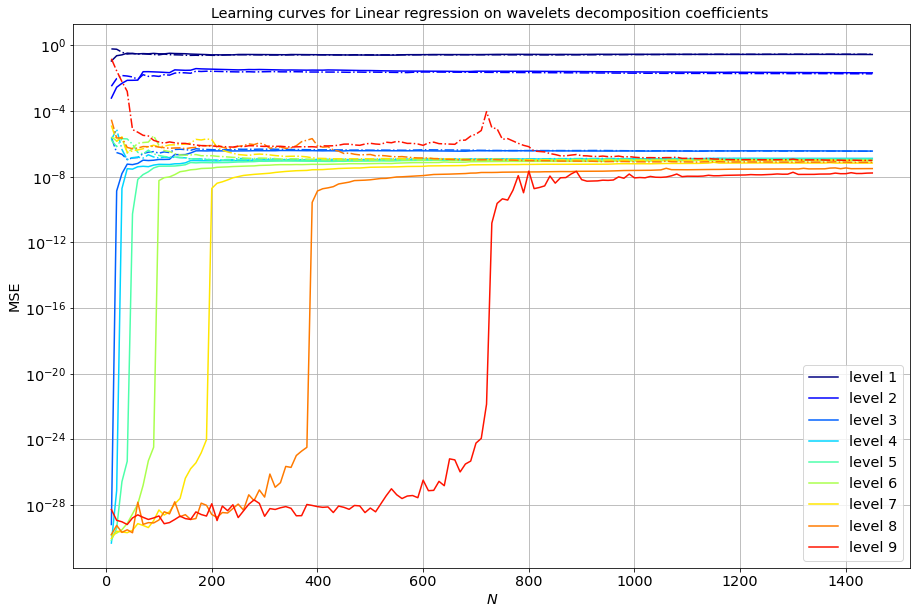

In [54]:
N=Nlevel
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

fig=plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

for ilevel in np.arange(1,Nlevel+1):
    ax.plot(nsamples,all_MSE_train[ilevel-1],"-",color=all_colors[ilevel-1],label="level {}".format(ilevel))
    ax.plot(nsamples,all_MSE_test[ilevel-1],"-.",color=all_colors[ilevel-1])

ax.legend()
ax.grid()
ax.set_title("Learning curves for Linear regression on wavelets decomposition coefficients ")
ax.set_yscale("log")
ax.set_xlabel("$N$")
ax.set_ylabel("MSE")

In [55]:
def plot_param(iparam,all_Yin,all_Yout):


    N=Nlevel
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)


    xlabel=["VAOD","PWV (mm)","Ozone (dBU)","Cloud OD"]
    ylabel="value rec - value in"
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    all_DY=np.array([], dtype=np.float64)
    for ilevel in np.arange(2,Nlevel):
        DY=all_Yout[ilevel]-all_Yin[ilevel]
        Y0=all_Yin[ilevel]
        all_DY=np.concatenate((all_DY,np.abs(DY[:,iparam])))
    
        ax.plot(Y0[:,iparam],DY[:,iparam],"o",color=all_colors[ilevel],label="level = {}".format(ilevel+1))
    ax.grid()
    ax.legend()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    ax.set_ylabel(ylabel)
    ax.set_ylim(-all_DY.max(),all_DY.max())
    
    plt.show()
    

In [56]:
def plot_param_histo(iparam,all_Yin,all_Yout):


    N=Nlevel
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(10,6))
    ax = fig.add_subplot(111)


    xlabel=["$\Delta VAOD$","$\Delta PWV $(mm)","$\Delta Ozone$ (dBU)","$\Delta$ OD"]
    ylabel="value rec - value in"
    ttitle=["Estimation of VAOD",
       "Estimation of PWV",
       "Estimation of Ozone",
       "Estimation of Cloud OD"]

    all_DY=np.array([], dtype=np.float64)
    all_Sig=np.zeros(N)
    all_label=[]
    
    for ilevel in np.arange(2,Nlevel):
        DY=all_Yout[ilevel]-all_Yin[ilevel]
        Y0=all_Yin[ilevel]
        all_DY=np.concatenate((all_DY,np.abs(DY[:,iparam])))
        all_Sig[ilevel]=np.std(DY[:,iparam])
    
        ax.hist(DY[:,iparam],bins=50,color=all_colors[ilevel],label="level = {}".format(ilevel+1))
        label="$\sigma_{}$ = {:.3g}".format(ilevel+1,all_Sig[ilevel])
        all_label.append(label)
    
    
    textstr = '\n'.join(all_label) 
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    # place a text box in upper left in axes coords
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
    
    ax.grid()
    ax.legend()
    ax.set_title(ttitle[iparam])
    ax.set_xlabel(xlabel[iparam])
    #ax.set_ylabel("nb s")
    ax.set_xlim(-all_DY.max(),all_DY.max())
    
    plt.show()
    

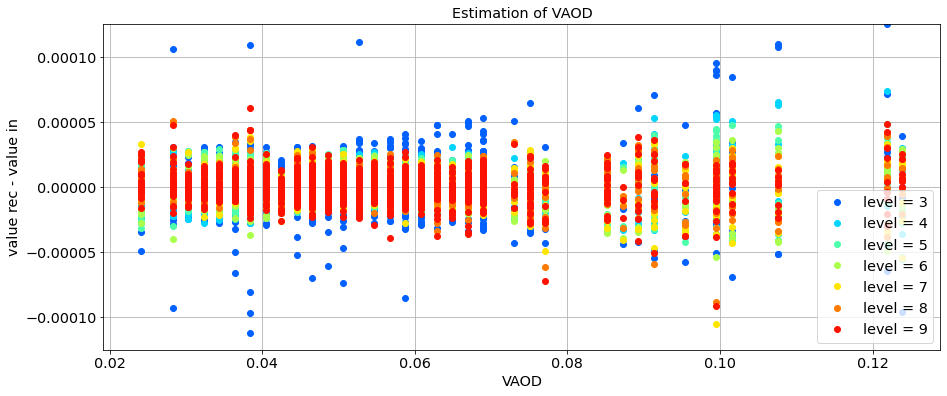

In [57]:
plot_param(0,all_Yin,all_Yout)

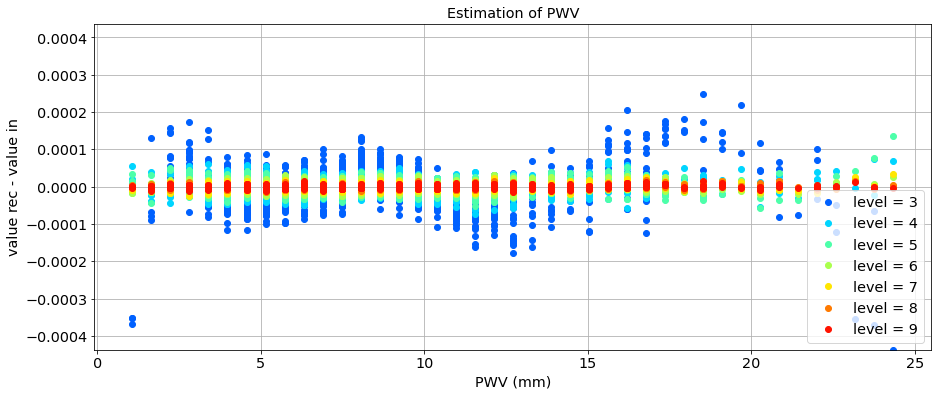

In [58]:
plot_param(1,all_Yin,all_Yout)

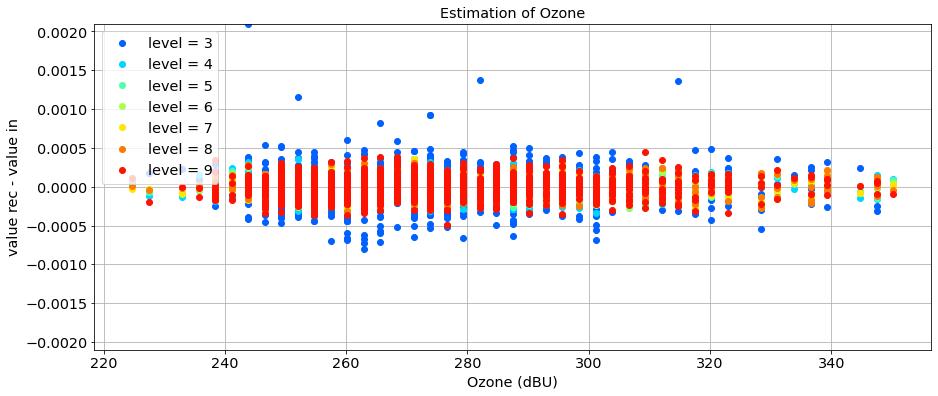

In [59]:
plot_param(2,all_Yin,all_Yout)

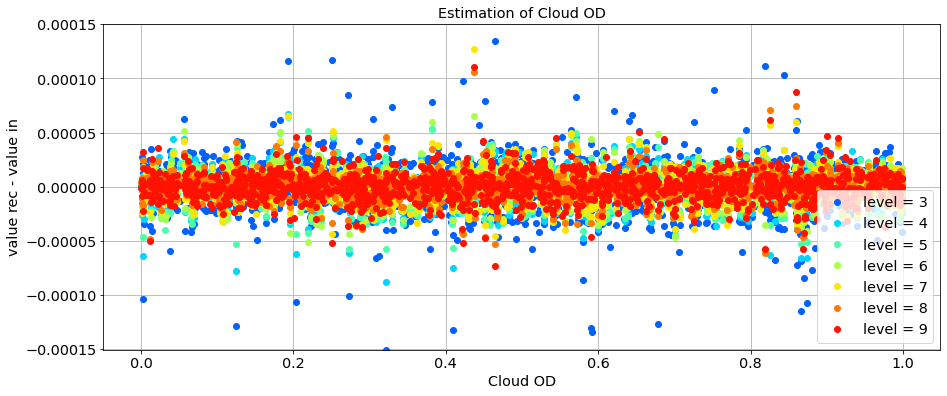

In [60]:
plot_param(3,all_Yin,all_Yout)

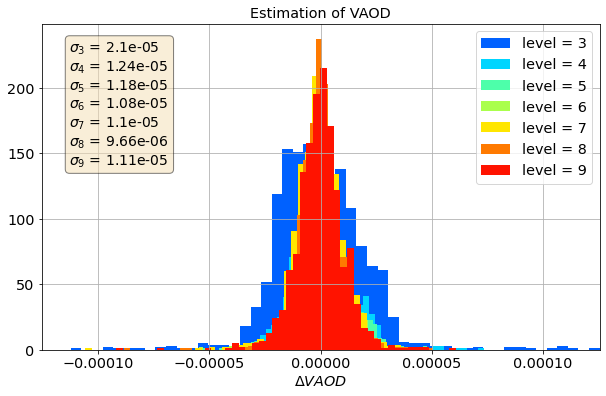

In [61]:
plot_param_histo(0,all_Yin,all_Yout)

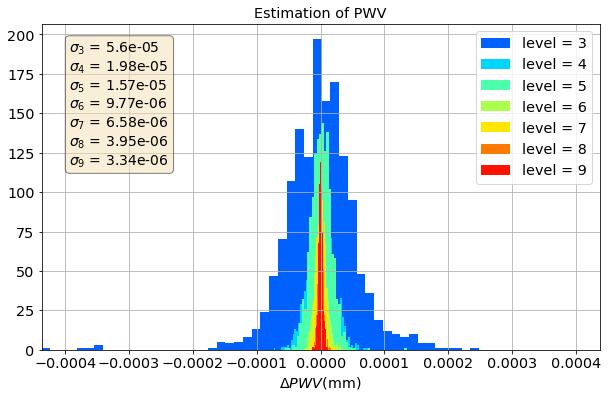

In [62]:
plot_param_histo(1,all_Yin,all_Yout)

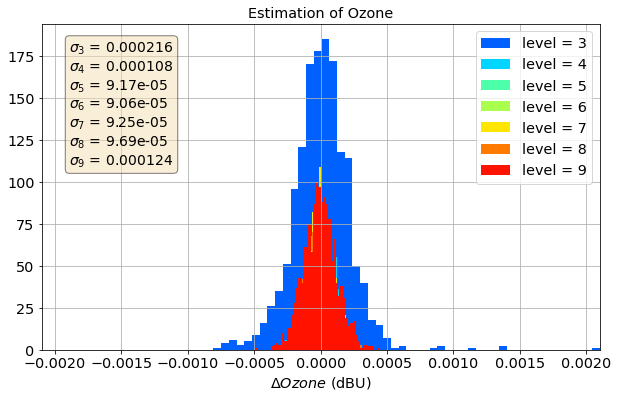

In [63]:
plot_param_histo(2,all_Yin,all_Yout)

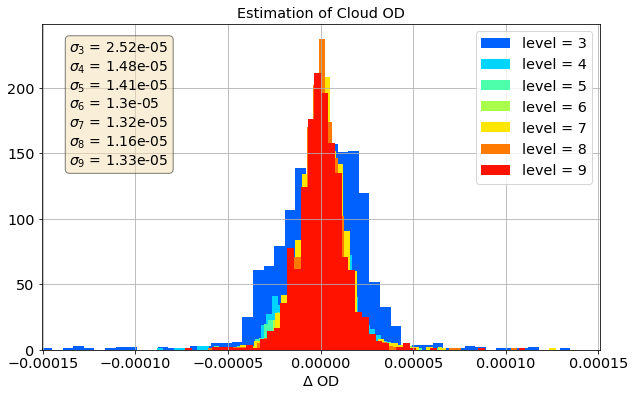

In [64]:
plot_param_histo(3,all_Yin,all_Yout)